# Concrete Fracture Detection with Supervised Learning
### Feature Extraction: Sum of Pixels of Binary Mask created by Canny edge detector 
### Classifier: Decision tree
### Feature Selection: Not-needed (single feature)

### AUTHORS: JOSE HIDALGO, PhD,  DIEGO FRIAS, PhD 

Feature extraction:

Our image pre-processing consists in the following steps:

1. Image conversion to gray scale
2. Determination of edges with CANNY method
3. Feature calculation: sum of pixels of the binary image (not normalized)

The result of the pre-processing step is the construction of a dataset with a single feature.

Training:

Tree classifier training consists in finding a feature value (classifier threshold) which minimizes the sum of false positives and negatives.



In [1]:
%matplotlib inline

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import  classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from PIL import Image

import numpy as np
from numpy import mean
from numpy import isnan
from numpy import asarray

import os
import shutil, glob, os.path

from tqdm import tqdm

import skimage
from skimage import data, io, color, exposure, feature

from skimage.filters import threshold_otsu 
from skimage.filters import rank

from skimage.feature import canny # edge extraction

from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte

from skimage.morphology import disk
from skimage.morphology import ball


In [2]:
POSITIVE_PATH = 'C:/Users/diego/OneDrive/Documentos/NOTEBOOKS/IA/Concrete/Positive'
NEGATIVE_PATH = 'C:/Users/diego/OneDrive/Documentos/NOTEBOOKS/IA/Concrete/Negative'

PosFiles=os.listdir(POSITIVE_PATH)
NegFiles=os.listdir(NEGATIVE_PATH)

nPosImg=len(PosFiles)
nNegImg=len(NegFiles)

print("number of positive images: ",nPosImg,"number of negative images: ",nNegImg)

number of positive images:  20000 number of negative images:  20000


In [16]:
ntrain_pos=5000
ntrain_neg=5000

ntest_pos=15000
ntest_neg=15000

INT_LENGTH = 16

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

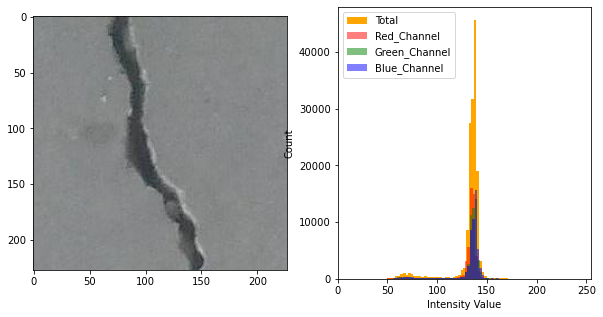

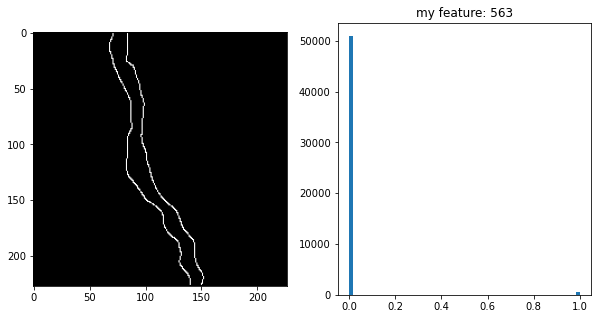

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.07s/it]

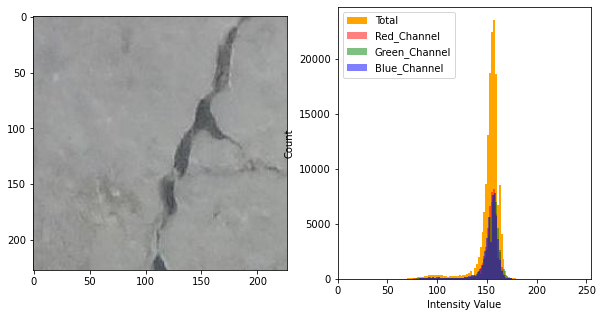

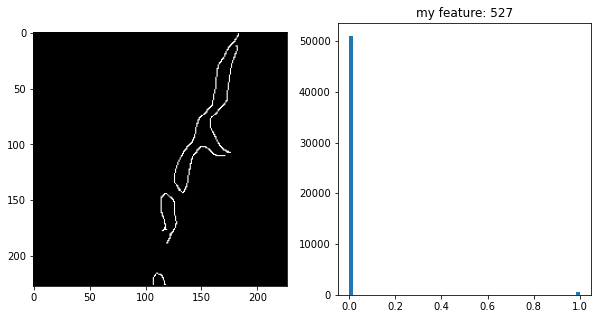

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.13s/it]

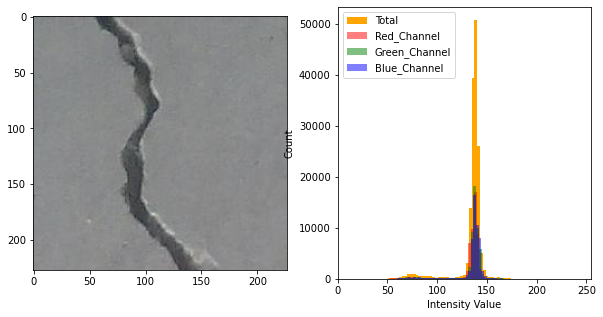

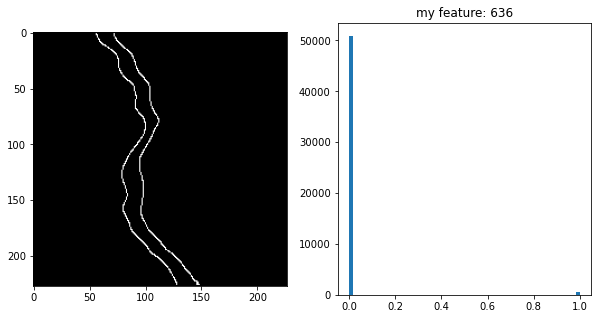

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

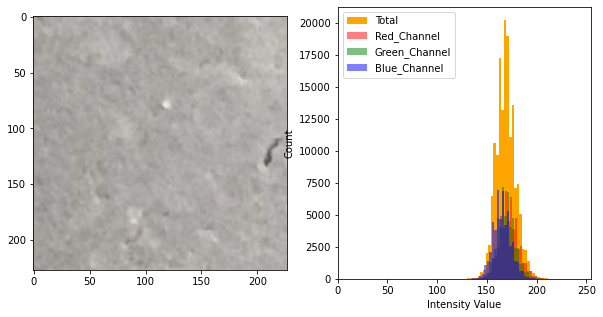

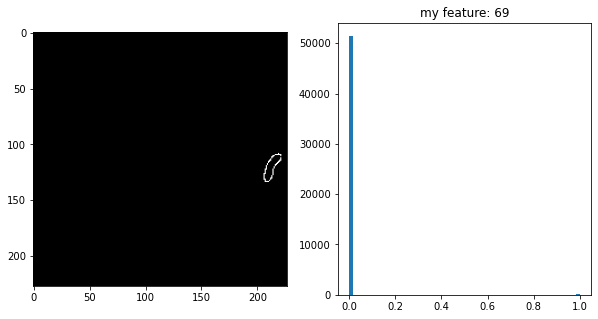

 33%|████████████████████████████                                                        | 1/3 [00:01<00:02,  1.16s/it]

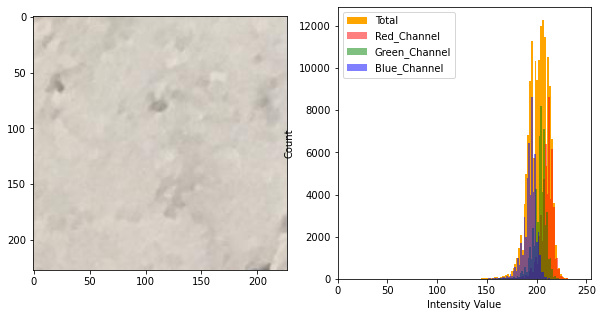

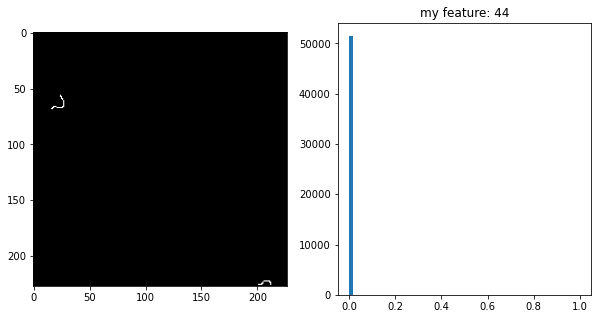

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.10s/it]

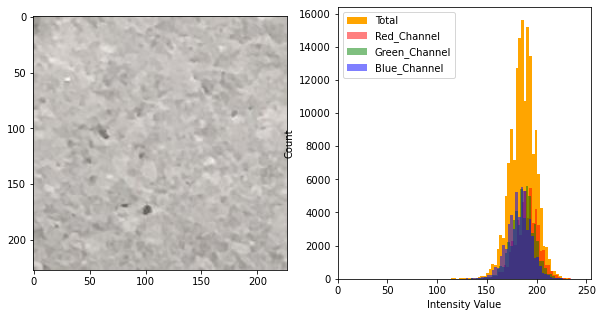

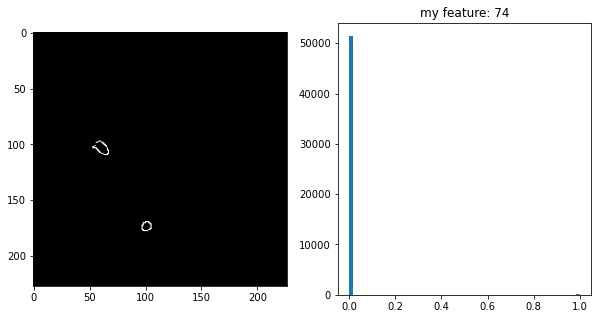

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


In [15]:
# histogram study

for file in tqdm(PosFiles[0:3]):
    path=os.path.join(POSITIVE_PATH, file)
    image = io.imread(path) # load image in np.array
    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    ax[0].imshow(image)   
    ax[1].hist(image.ravel(), bins = 64, color = 'orange', )
    ax[1].hist(image[:, :, 0].ravel(), bins = 64, color = 'red', alpha = 0.5)
    ax[1].hist(image[:, :, 1].ravel(), bins = 64, color = 'Green', alpha = 0.5)
    ax[1].hist(image[:, :, 2].ravel(), bins = 64, color = 'Blue', alpha = 0.5)
    ax[1].set_xlim(0, 255)
    ax[1].set_xlabel('Intensity Value')
    ax[1].set_ylabel('Count')
    ax[1].legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.show()
    if image.shape[2]>=3: # if RGB or similar
        image = color.rgb2gray(image) # transform to grayscale 
    # Compute the Canny filter 
    sigma=3
    edges = feature.canny(image, sigma=sigma)
    figb, axb = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    my_feature=np.sum(edges.astype(int))
    axb[0].imshow(edges, cmap='gray')
    axb[1].hist(np.reshape(edges.astype(int),edges.shape[0]*edges.shape[1]), bins = 64)
    axb[1].set_title('my feature: '+str(my_feature))
    fig.tight_layout()
    plt.show()
    
for file in tqdm(NegFiles[0:3]):
    path=os.path.join(NEGATIVE_PATH, file)
    image = io.imread(path) # load image in np.array
    fig2, ax2 = plt.subplots(1,2, figsize=(10, 5))
    ax2[0].imshow(image)
    ax2[1].hist(image.ravel(), bins = 64, color = 'orange', )
    ax2[1].hist(image[:, :, 0].ravel(), bins = 64, color = 'red', alpha = 0.5)
    ax2[1].hist(image[:, :, 1].ravel(), bins = 64, color = 'Green', alpha = 0.5)
    ax2[1].hist(image[:, :, 2].ravel(), bins = 64, color = 'Blue', alpha = 0.5)
    ax2[1].set_xlim(0, 255)
    ax2[1].set_xlabel('Intensity Value')
    ax2[1].set_ylabel('Count')
    ax2[1].legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.show()
    if image.shape[2]>=3: # if RGB or similar
        image = color.rgb2gray(image) # transform to grayscale 
     # Compute the Canny filter 
    sigma=3
    edges = feature.canny(image, sigma=sigma)
    figa, axa = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    my_feature2=np.sum(edges.astype(int))
    axa[0].imshow(edges, cmap='gray')
    axa[1].hist(np.reshape(edges.astype(int),edges.shape[0]*edges.shape[1]), bins = 64)
    axa[1].set_title('my feature: '+str(my_feature2))
    fig.tight_layout()
    plt.show()
    

In [7]:
# my simplified solution

# reading training dataset calculating my feature for each image

my_feature_pos=[]
for file in tqdm(PosFiles[:ntrain_pos]):
#     for file in tqdm(PosFiles[:HNSAMPLES]):
    path=os.path.join(POSITIVE_PATH, file)
    image = io.imread(path) # load image in np.array
    if image.shape[2]>=3: # if RGB or similar
        image = color.rgb2gray(image) # transform to grayscale 
        sigma=3
    edges = feature.canny(image, sigma=sigma)
    my_feature_pos.append(np.sum(edges.astype(int)))
    
#     Img = image > threshold_value  # filtering the image
#     my_feature_pos.append(np.sum(1-Img.astype(int)))
    
my_feature_neg=[]
for file in tqdm(NegFiles[:ntrain_neg]):
#     for file in tqdm(NegFiles[:HNSAMPLES]):
    path=os.path.join(NEGATIVE_PATH, file)
    image = io.imread(path) # load image in np.array
    if image.shape[2]>=3: # if RGB or similar
        image = color.rgb2gray(image) # transform to grayscale 
                          
    edges = feature.canny(image, sigma=sigma)
    my_feature_neg.append(np.sum(edges.astype(int)))
                          
#     Img = image > threshold_value  # filtering the image
#     my_feature_neg.append(np.sum(1-Img.astype(int)))
    


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:23<00:00, 34.90it/s]


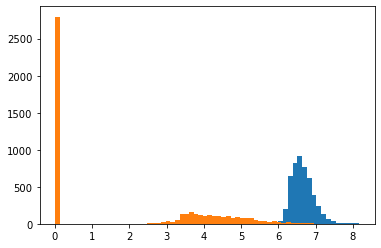

min pos:  0  max pos:  3553  mean pos:  802.156  stdev pos:  290.69594366623005
min neg:  0  max neg:  2820 mean neg:  55.8272  stdev neg:  137.42281520970235


In [8]:
# ploting histograms of my feature for positive and negative images

# normalizing my feature with image size

n_pixels=image.shape[0]*image.shape[1]

fpos=np.asarray(my_feature_pos) #/n_pixels
fneg=np.asarray(my_feature_neg)#/n_pixels

plt.hist(np.log1p(fpos),bins=64)
plt.hist(np.log1p(fneg),bins=64)
plt.show()

avg_pos=np.mean(fpos)
avg_neg=np.mean(fneg)

print("min pos: ",np.min(fpos)," max pos: ",np.max(fpos),\
      " mean pos: ",avg_pos," stdev pos: ",np.std(fpos))
print("min neg: ",np.min(fneg)," max neg: ",np.max(fneg),\
     "mean neg: ",avg_neg," stdev neg: ",np.std(fneg))

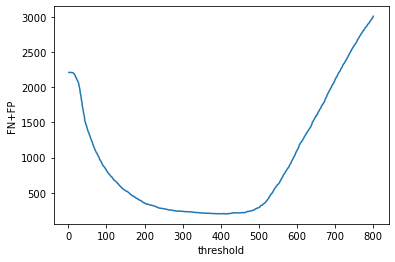

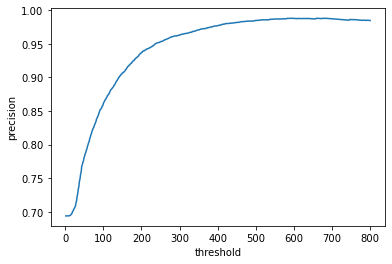

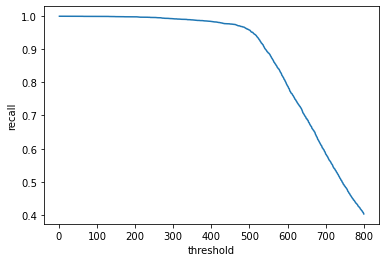

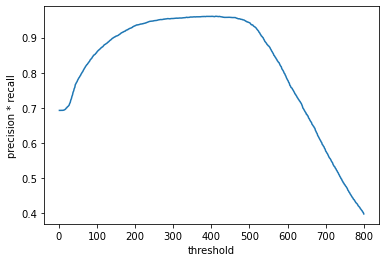

optimal threshold for my feature minimizing falses :  411.9734976
optimal threshold for my feature maximizing product recall*precision:  411.9734976


In [9]:
# calculating the optimal classifier threshold that inimizes falses (positive nd negative)

nsteps=500 # resolution of the treshold

dstep=(avg_pos-avg_neg)/nsteps
falses=[]
thres=[]

FN=[]
FP=[]
TN=[]
TP=[]
precision=[]
recall=[]

for t in np.arange(dstep,avg_pos-dstep,dstep):
    
    FN.append(np.sum(fpos<=t))
    
    FP.append(np.sum(fneg>t))
    
    TP.append(np.sum(fpos>t))
    
    TN.append(np.sum(fneg<=t))
    
    falses.append(FN[-1]+FP[-1]) # falsos é a soma de todas as images pos cujas features são <= threshold t 
    # e todas as imagens negativas cuja feature é maior que o threshold t
    
    precision.append(TP[-1]/(TP[-1]+FP[-1]))
    
    recall.append(TP[-1]/ntrain_pos)
                     
    thres.append(t)
    
#     print("TP ",TP[-1],ntrain_pos)
#     print("TN ",TN[-1],ntrain_neg)
    
plt.plot(thres,falses)
plt.xlabel('threshold')
plt.ylabel('FN+FP')
plt.ylabel
plt.show()

plt.plot(thres,precision)
plt.xlabel('threshold')
plt.ylabel('precision')
plt.ylabel
plt.show()
                     
plt.plot(thres,recall)
plt.xlabel('threshold')
plt.ylabel('recall')
plt.ylabel
plt.show()

plt.plot(thres,np.multiply(precision,recall))
plt.xlabel('threshold')
plt.ylabel('precision * recall')
plt.ylabel
plt.show()
                     
my_opt_thres=thres[np.argmin(falses)]
print("optimal threshold for my feature minimizing falses : ",my_opt_thres)

my_opt_thres2=thres[np.argmax(np.multiply(precision,recall))]
print("optimal threshold for my feature maximizing product recall*precision: ",my_opt_thres2)


In [11]:
# testing my single feature classifier

# reading test dataset calculating my feature for each image

FALSE_POS=0
FALSE_NEG=0
TRUE_POS=0
TRUE_NEG=0

myY_pred=[]
myY_true=[]

pos_falses=[]
pos_falses2=[]
for file in tqdm(PosFiles[ntrain_pos:ntrain_pos+ntest_pos]):
#     for file in tqdm(PosFiles[:HNSAMPLES]):
    path=os.path.join(POSITIVE_PATH, file)
    image = io.imread(path) # load image in np.array
    if image.shape[2]>=3: # if RGB or similar
        image = color.rgb2gray(image) # transform to grayscale 
    edges = feature.canny(image, sigma=sigma)
    if np.sum(edges.astype(int)) <= my_opt_thres:
        FALSE_NEG+=1
        myY_pred.append(0)
        pos_falses.append(io.imread(path))
        pos_falses2.append(edges)
    else:
        TRUE_POS+=1
        myY_pred.append(1)
    myY_true.append(1)
    
neg_falses=[]
neg_falses2=[]
for file in tqdm(NegFiles[ntrain_neg:ntrain_neg+ntest_neg]):
#     for file in tqdm(NegFiles[:HNSAMPLES]):
    path=os.path.join(NEGATIVE_PATH, file)
    image = io.imread(path) # load image in np.array
    if image.shape[2]>=3: # if RGB or similar
        image = color.rgb2gray(image) # transform to grayscale 
    edges = feature.canny(image, sigma=sigma)
    if np.sum(edges.astype(int)) > my_opt_thres:
        FALSE_POS+=1
        myY_pred.append(1)
        neg_falses.append(io.imread(path))
        neg_falses2.append(edges)
    else:
        TRUE_NEG+=1
        myY_pred.append(0)
    myY_true.append(0)


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [07:50<00:00, 31.87it/s]


In [12]:
# metrics

# AUTOMATIC
print(classification_report(myY_true,myY_pred))

# MANUAL
print("MANUALLY CALCULATED")
# accuracy
acc=(TRUE_POS+TRUE_NEG)/(ntest_pos+ntest_neg)
print('accuracy :',acc)
# TPR - recall, sensitivity
TPR = TRUE_POS/ntest_pos
# TNR - specificity, selectivity
TNR = TRUE_NEG/ntest_neg
# balanced accuracy
bacc=0.5*(TPR+TNR)
print('balanced accuracy :',bacc)
# f1-score
f1=2*TRUE_POS/(2*TRUE_POS+FALSE_POS+FALSE_NEG)
print("f1-score: ",f1)
# precision 
prec=TRUE_POS/(TRUE_POS+FALSE_POS)
print('precision: ',prec)
print('recall: ',TPR)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     15000
           1       0.98      0.98      0.98     15000

    accuracy                           0.98     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000

MANUALLY CALCULATED
accuracy : 0.9807
balanced accuracy : 0.9807
f1-score:  0.9807019298070193
precision:  0.9806038792241552
recall:  0.9808


In [ ]:
# JUST WORKS FOR BINARY CLASSIFIERS

def ROC_AUC(classifier, kfold, X, y):
    
    cv = StratifiedKFold(n_splits=kfold)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()
    
    

positive - FN


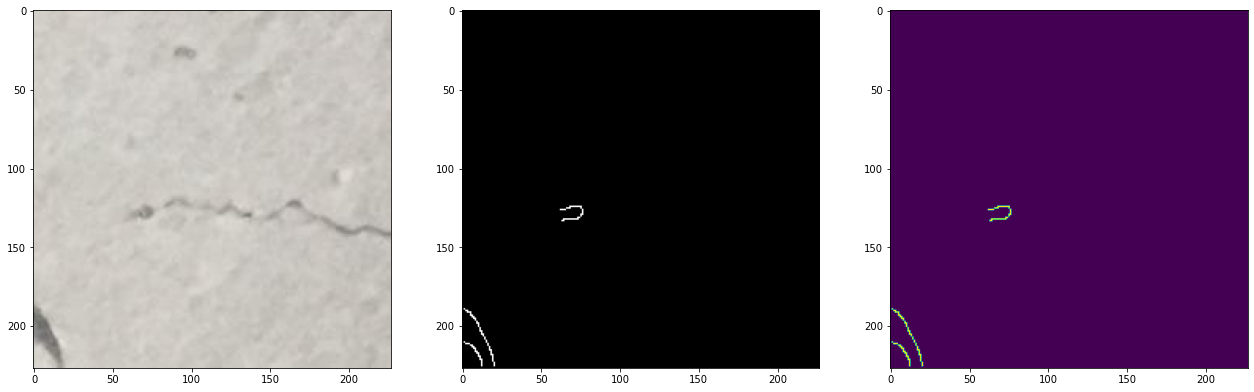

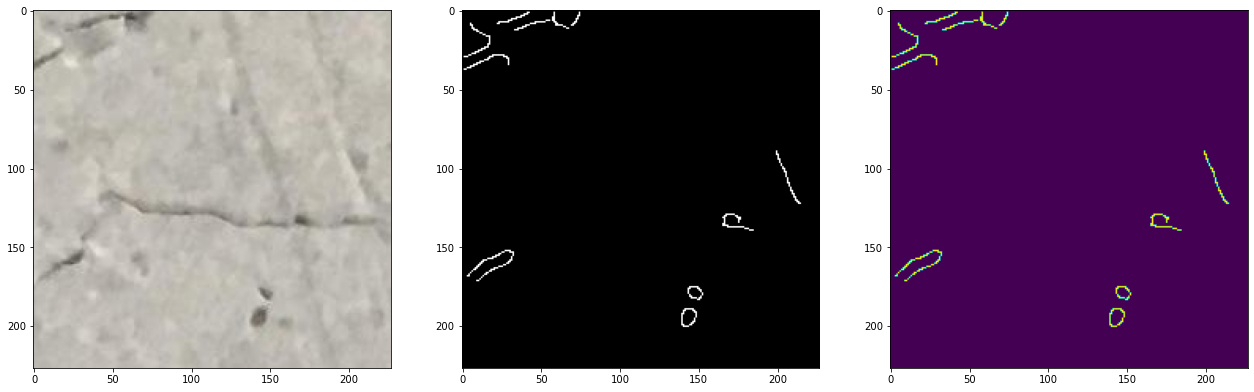

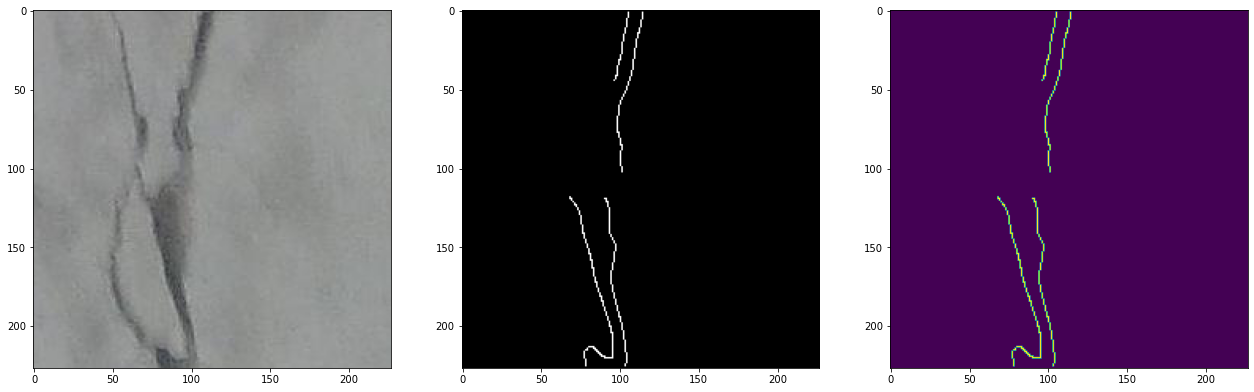

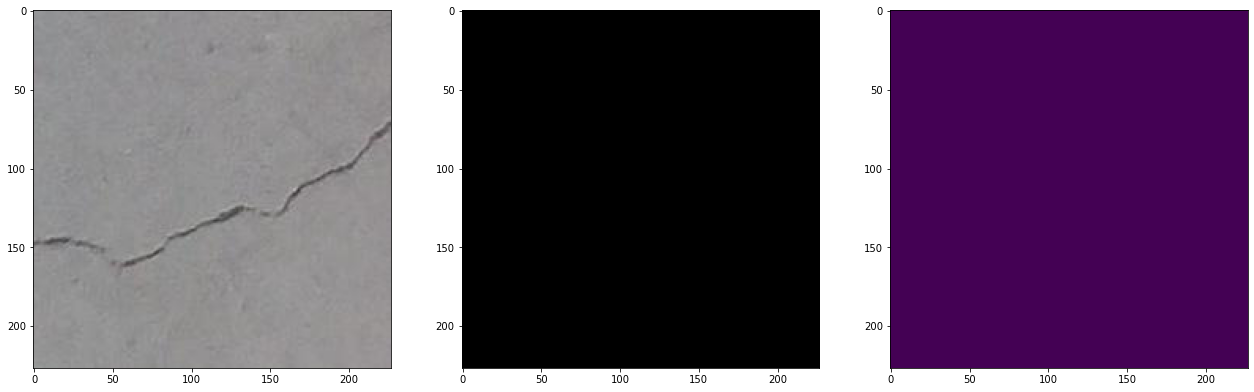

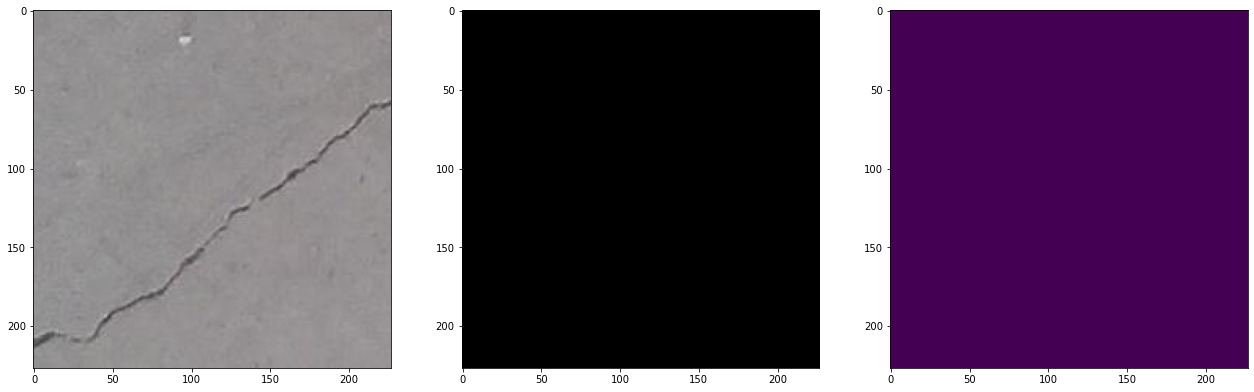

negative - FP


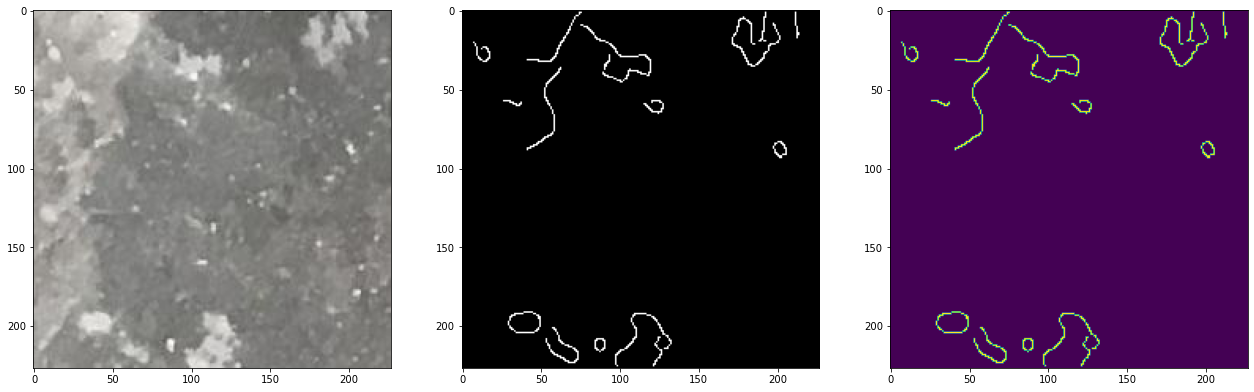

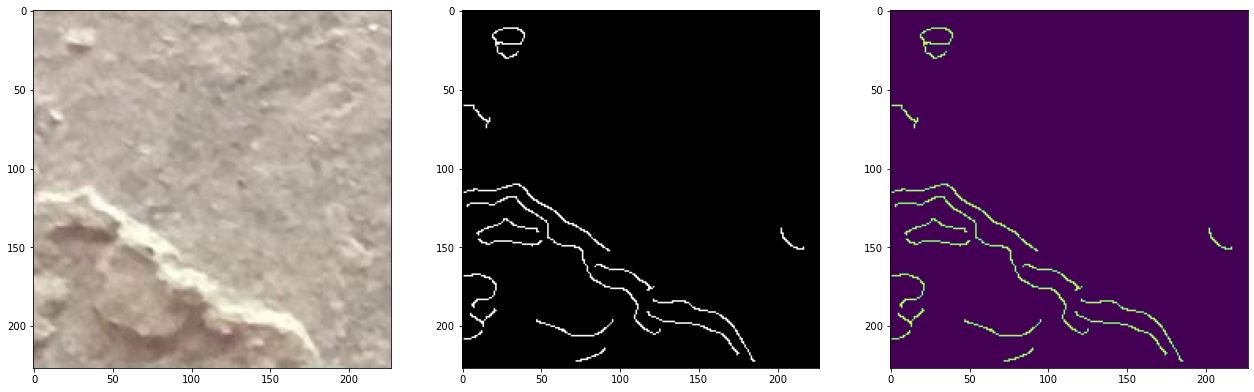

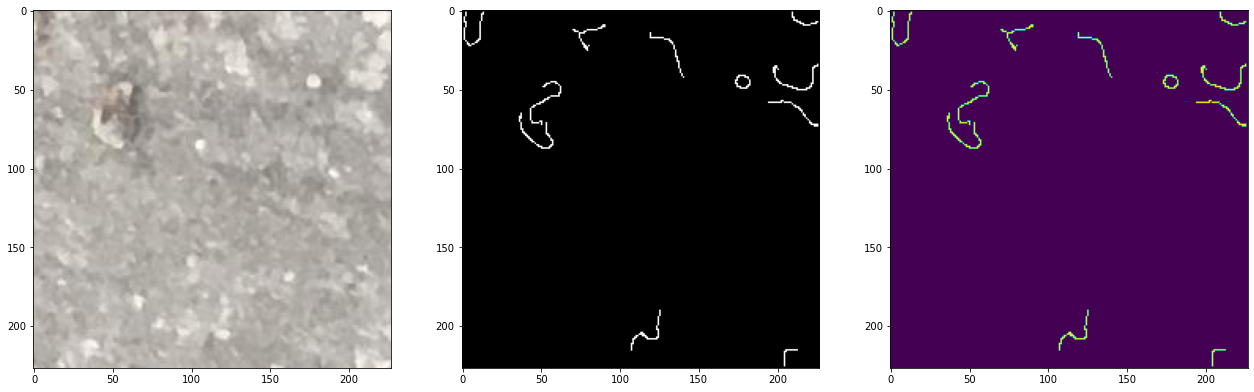

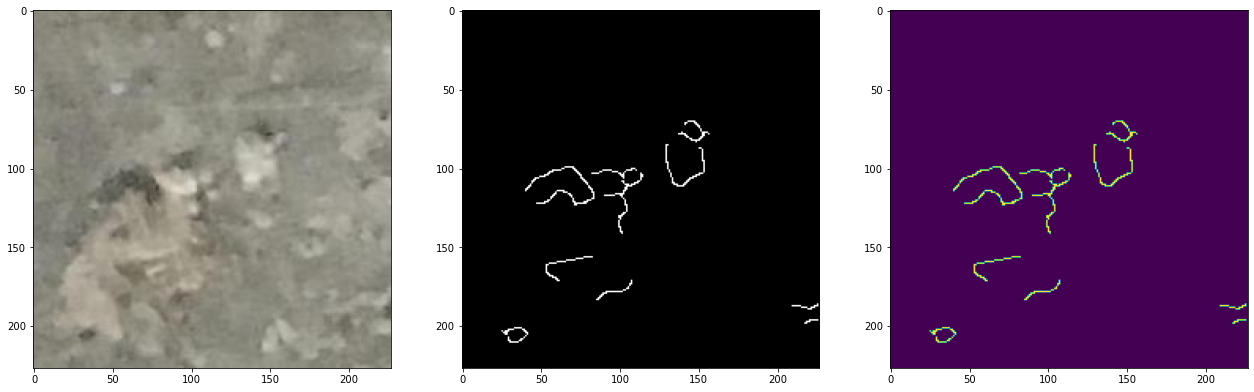

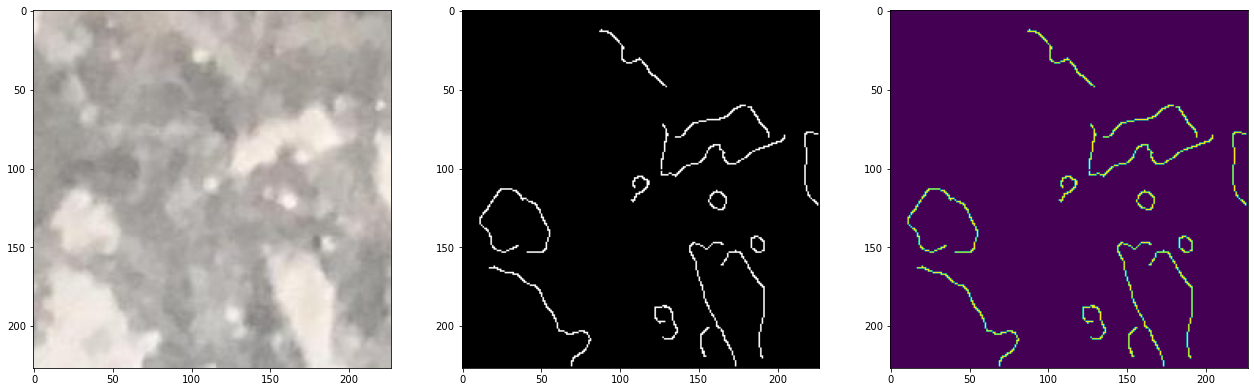

In [13]:
# INSPECTION OF FALSES (ABDUCTIVE APPROACH)

print('positive - FN')
for i, image in enumerate(pos_falses[:5]):
    fig, ax = plt.subplots(1,3, figsize=(18, 5.5))
    ax[0].imshow(image)   
    ax[1].imshow(pos_falses2[i], cmap=plt.cm.gray)   
    # Compute the Canny filter 
    sigma=3
    if image.shape[2]>=3: # if RGB or similar
        image = color.rgb2gray(image) # transform to grayscale 
    edges = feature.canny(image, sigma=sigma)
    ax[2].imshow(edges)
#     ax[2].hist(np.reshape(edges.astype(int),edges.shape[0]*edges.shape[1]), bins = 64)
    fig.tight_layout()
    plt.show()
    
print('negative - FP')
for i, image in enumerate(neg_falses[:5]):
    fig, ax = plt.subplots(1,3, figsize=(18, 5.5))
    ax[0].imshow(image)   
    ax[1].imshow(neg_falses2[i], cmap=plt.cm.gray) 
    # Compute the Canny filter 
    sigma=3
    if image.shape[2]>=3: # if RGB or similar
        image = color.rgb2gray(image) # transform to grayscale 
    edges = feature.canny(image, sigma=sigma)
    ax[2].imshow(edges)
#     ax[2].hist(np.reshape(edges.astype(int),edges.shape[0]*edges.shape[1]), bins = 64)
    fig.tight_layout()
    plt.show()
    
    
# skimage.exposure.adjust_gamma(image[, …])

# Performs Gamma Correction on the input image.

# skimage.exposure.adjust_log(image[, gain, inv])

# Performs Logarithmic correction on the input image.

# skimage.exposure.adjust_sigmoid(image[, …])

# Performs Sigmoid Correction on the input image.

# skimage.exposure.cumulative_distribution(image)

# Return cumulative distribution function (cdf) for the given image.

# skimage.exposure.equalize_adapthist(image[, …])

# Contrast Limited Adaptive Histogram Equalization (CLAHE).

# skimage.exposure.equalize_hist(image[, …])

# Return image after histogram equalization.

# skimage.exposure.histogram(image[, nbins, …])

# Return histogram of image.

# skimage.exposure.is_low_contrast(image[, …])

# Determine if an image is low contrast.

# skimage.expo


In [ ]:
# CLASSIFICATION METRICS 

# BINARY CLASSIFICATION ONLY

# precision_recall_curve(y_true, probas_pred, *) Compute precision-recall pairs for different probability thresholds.

# roc_curve(y_true, y_score, *[, pos_label, …]) Compute Receiver operating characteristic (ROC).

# det_curve(y_true, y_score[, pos_label, …]) Compute error rates for different probability thresholds.


# MULTICLASS CASE:

# balanced_accuracy_score(y_true, y_pred, *[, …]) Compute the balanced accuracy.

# cohen_kappa_score(y1, y2, *[, labels, …]) Cohen’s kappa: a statistic that measures inter-annotator agreement.

# confusion_matrix(y_true, y_pred, *[, …]) Compute confusion matrix to evaluate the accuracy of a classification.

# hinge_loss(y_true, pred_decision, *[, …]) Average hinge loss (non-regularized).

# matthews_corrcoef(y_true, y_pred, *[, …]) Compute the Matthews correlation coefficient (MCC).

# roc_auc_score(y_true, y_score, *[, average, …]) Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

# top_k_accuracy_score(y_true, y_score, *[, …]) Top-k Accuracy classification score.

# MULTILABEL CASE:

# accuracy_score(y_true, y_pred, *[, …]) Accuracy classification score.

# classification_report(y_true, y_pred, *[, …]) Build a text report showing the main classification metrics.

# f1_score(y_true, y_pred, *[, labels, …]) Compute the F1 score, also known as balanced F-score or F-measure.

# fbeta_score(y_true, y_pred, *, beta[, …]) Compute the F-beta score.

# hamming_loss(y_true, y_pred, *[, sample_weight]) Compute the average Hamming loss.

# jaccard_score(y_true, y_pred, *[, labels, …]) Jaccard similarity coefficient score.

# log_loss(y_true, y_pred, *[, eps, …]) Log loss, aka logistic loss or cross-entropy loss.

# multilabel_confusion_matrix(y_true, y_pred, *) Compute a confusion matrix for each class or sample.

# precision_recall_fscore_support(y_true, …) Compute precision, recall, F-measure and support for each class.

# precision_score(y_true, y_pred, *[, labels, …]) Compute the precision.

# recall_score(y_true, y_pred, *[, labels, …]) Compute the recall.

# roc_auc_score(y_true, y_score, *[, average, …]) Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

# zero_one_loss(y_true, y_pred, *[, …])  Zero-one classification loss.